In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
from pathlib import Path
import datetime as dt
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import json


In [3]:
RDBENCH_OUTPUT_DIR = Path("../raw/rdbench")

df_src = pl.DataFrame([
    {
        key: value
        for key, value in json.loads(json_file.read_text()).items()
        if key != "phaseDurationsSec"
    }
    for log_dir in RDBENCH_OUTPUT_DIR.glob("*")
    for json_file in log_dir.glob("rdbench_*.json")
])

df_src.head(5)

version,nprocs,topology,xnp,ynp,L,chunkSizeX,chunkSizeY,collective,iotype,sync,validate,steps,interval,fixedX,fixedY,initialOutput,nfiles,fileSize,totalWriteSizeByte,calcTimeSec,commTimeSec,writeTimeSec,writeBandwidthByte,initialTimeSec,finalizeTimeSec
str,i64,list[i64],i64,i64,i64,i64,i64,bool,str,bool,bool,i64,i64,bool,bool,bool,i64,i64,i64,f64,f64,f64,f64,f64,f64
"""0.11.1""",32,[32],4,8,32768,8192,4096,false,"""view""",false,false,640,64,false,false,false,10,8589934592,85899345920,123.429105,9.23613,3.537575,2.4282e10,6.985206,37.088067
"""0.11.1""",16,[16],4,4,32768,8192,8192,false,"""view""",false,false,640,64,false,false,false,10,8589934592,85899345920,260.376991,28.26484,7.438718,1.1548e10,6.824588,44.06004


nprocs,bwMB
i64,f64
16,11547.600249
32,24281.987167


Text(0.5, 1.0, 'RDBench Write')

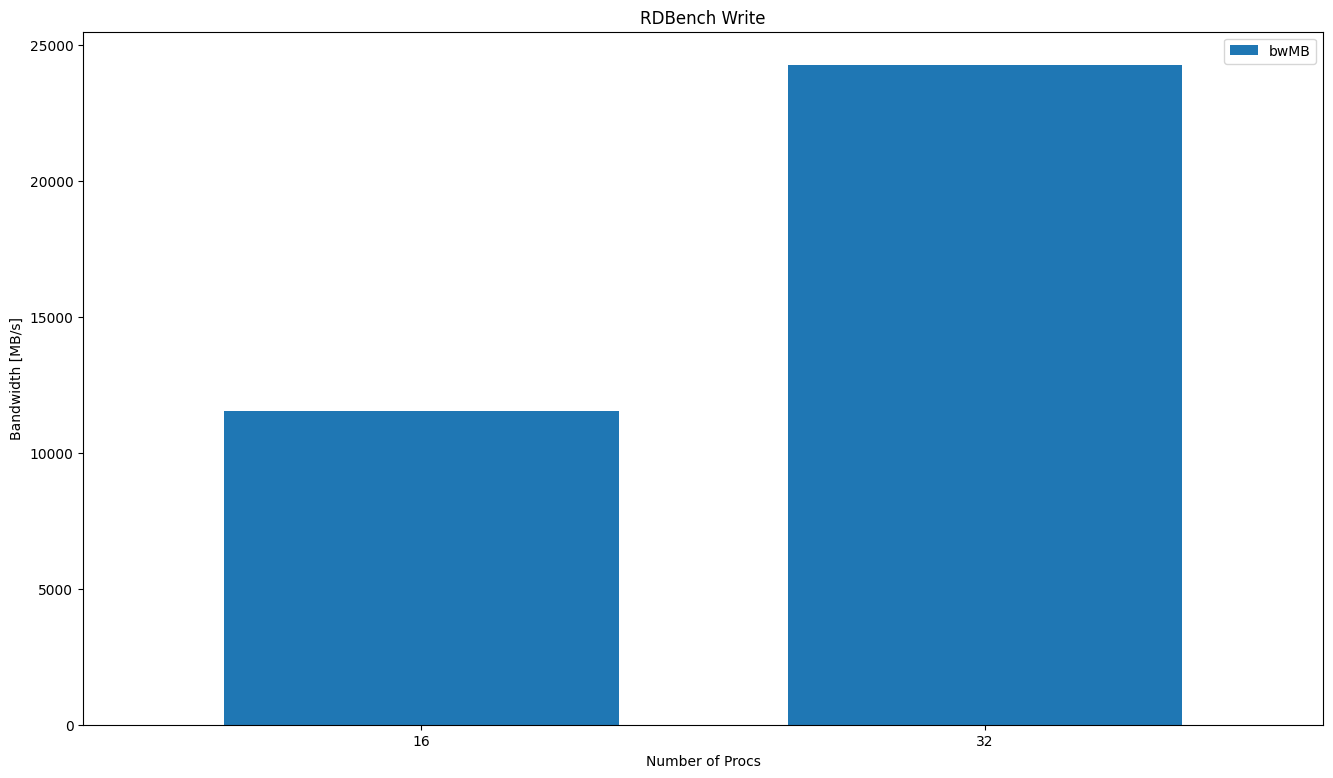

In [4]:
df = df_src

fig = plt.figure(figsize=(16, 9), dpi=100)
fig.patch.set_alpha(1)
ax = (
    df
    .group_by("nprocs")
    .agg([
        pl.mean("writeBandwidthByte"),
    ])
    .sort("nprocs")
    .with_columns(bwMB=pl.col("writeBandwidthByte") / 10**6)
    .select(["nprocs", "bwMB"])
    .pipe(lambda df: (display(df), df)[-1])
    .to_pandas()
    .set_index("nprocs")
    .plot(
        ax=fig.add_subplot(),
        kind="bar",
        xlabel="Number of Procs",
        ylabel="Bandwidth [MB/s]",
        rot=0,
        width=0.7,
    )
)
ax.set_title("RDBench Write")